Upload your Excel files (e.g., AAPL.xlsx, NVDA.xlsx, TSLA.xlsx, etc.)


Saving Price History_IEF5.xlsx to Price History_IEF5.xlsx
Files uploaded: ['Price History_IEF5.xlsx']

== Augmented Dickey-Fuller (ADF) Unit Root Test Results ==

Price History_IEF5:
  ADF Statistic: -1.2142
  p-value: 0.6674
  Non-stationary

== Stock Buy Recommendation Based on Stationarity (ADF Test) ==
Price History_IEF5: Non-stationary (p-value=0.6674) → DO NOT BUY FOR MEAN-REVERSION STRATEGY (non-stationary, price behaves more like a random walk)

== Differencing Non-Stationary Series ==
Price History_IEF5 is non-stationary (p-value=0.6674). Applying first differencing...
  After differencing: Stationary (p-value=0.0000)

== ARIMA Model Summary for Each Series ==

Price History_IEF5 (Non-stationary) - ARIMA(1,1,1):
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  425
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 905.890
Date:                Thu, 12 Jun

<Figure size 800x400 with 0 Axes>

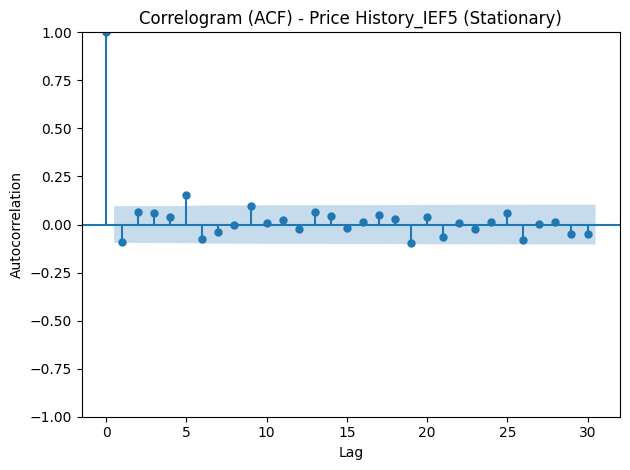


== Cointegration Test Results (Engle-Granger, Stationary Series) ==
Need at least two series to perform cointegration tests.

== Random Walk Simulation Example ==


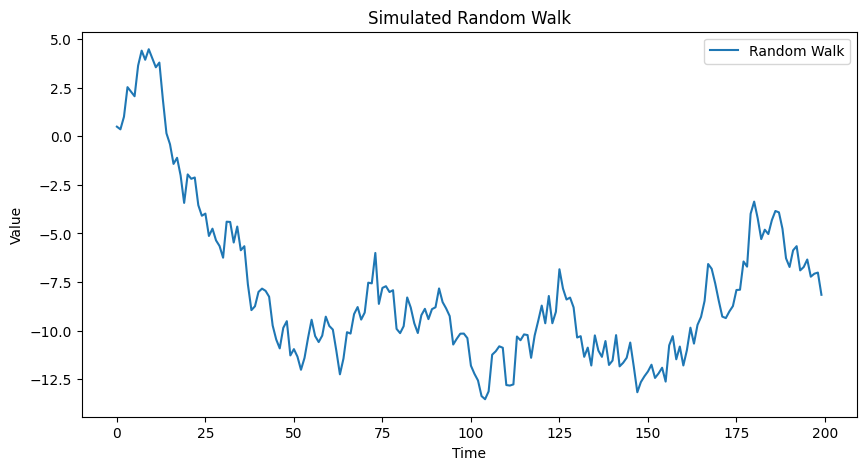

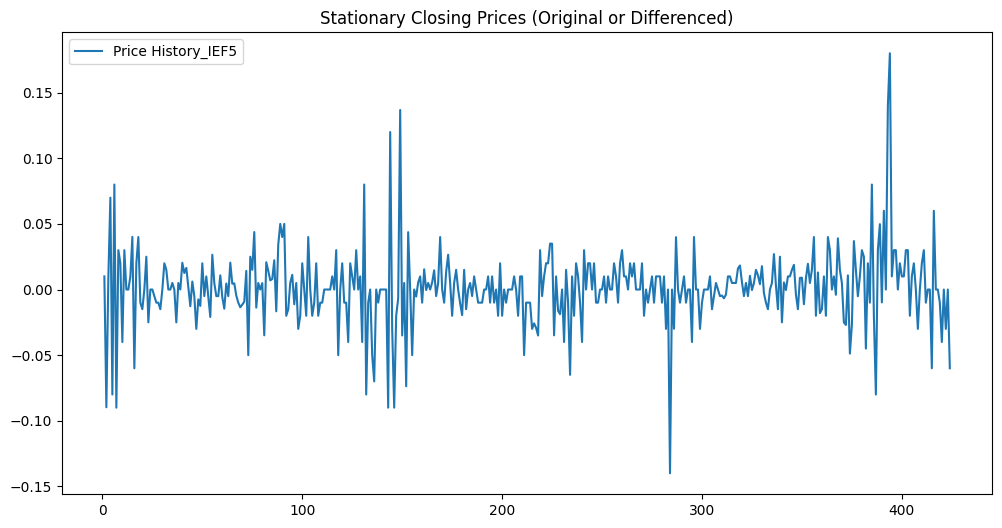


== Suggested Holding Period (Mean-Reversion Time) for Each Stationary Series (in hours) ==
Price History_IEF5: Estimated mean-reversion half-life is 7.0 hours.
  Suggestion: Hold for approximately 7 hours after a significant move for mean reversion.

== Sell Price Recommendation Based on ARIMA Mean and GARCH Volatility Forecast ==
Price History_IEF5: No GARCH model available, cannot recommend sell price based on volatility.

  - Price History_IEF5


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
<ipython-input-6-1423525566>:175: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  phi = model_fit.params[1]  # AR(1) coefficient


In [6]:
# 1. Install and import necessary libraries
!pip install --quiet statsmodels openpyxl arch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, coint
from google.colab import files
import io
import math
from arch import arch_model  # NEW: for GARCH

# 2. Upload files
print("Upload your Excel files (e.g., AAPL.xlsx, NVDA.xlsx, TSLA.xlsx, etc.)")
uploaded = files.upload()
print("Files uploaded:", list(uploaded.keys()))  # Optional debug

# 3. Read 'Close' columns from each file and collect in a dictionary
data = {}
for fname in uploaded.keys():
    df = pd.read_excel(io.BytesIO(uploaded[fname]))
    # Try to find 'Close' column case-insensitively
    close_col = next((col for col in df.columns if col.lower() == 'close'), None)
    if close_col is None:
        print(f"Warning: 'Close' column not found in {fname}. Skipping this file.")
        continue  # Skip to the next file if 'Close' column is not found
    # Store series with filename (without extension) as key
    key = fname.split('.')[0]
    data[key] = df[close_col].dropna().reset_index(drop=True)

# Check if any data was loaded
if not data:
    print("No valid data loaded from uploaded files. Please ensure your files contain a 'Close' column.")
else:
    # 4. Unit root test (ADF) for each series
    print("\n== Augmented Dickey-Fuller (ADF) Unit Root Test Results ==")
    adf_results = {}
    for name, series in data.items():
        adf_result = adfuller(series)
        adf_results[name] = adf_result
        print(f"\n{name}:")
        print(f"  ADF Statistic: {adf_result[0]:.4f}")
        print(f"  p-value: {adf_result[1]:.4f}")
        print("  Stationary" if adf_result[1] < 0.05 else "  Non-stationary")

    # 4b. Recommendation
    print("\n== Stock Buy Recommendation Based on Stationarity (ADF Test) ==")
    for name, adf_result in adf_results.items():
        p_value = adf_result[1]
        if p_value < 0.05:
            print(f"{name}: Stationary (p-value={p_value:.4f}) → RECOMMEND CONSIDERING BUY (stationary, may be suitable for mean-reversion strategies)")
        else:
            print(f"{name}: Non-stationary (p-value={p_value:.4f}) → DO NOT BUY FOR MEAN-REVERSION STRATEGY (non-stationary, price behaves more like a random walk)")

    # 4c. Convert Non-Stationary Series to Stationary (First Differencing)
    print("\n== Differencing Non-Stationary Series ==")
    stationary_data = {}
    for name, adf_result in adf_results.items():
        series = data[name]
        p_value = adf_result[1]
        if p_value < 0.05:
            print(f"{name} is already stationary (p-value={p_value:.4f}).")
            stationary_data[name] = series
        else:
            print(f"{name} is non-stationary (p-value={p_value:.4f}). Applying first differencing...")
            differenced = series.diff().dropna()
            diff_adf = adfuller(differenced)
            if diff_adf[1] < 0.05:
                print(f"  After differencing: Stationary (p-value={diff_adf[1]:.4f})")
            else:
                print(f"  Still non-stationary after first differencing (p-value={diff_adf[1]:.4f})")
            stationary_data[name] = differenced

    # 5. Fit ARIMA models for each series (stationary and non-stationary)
print("\n== ARIMA Model Summary for Each Series ==")
arima_models = {}
arima_residuals = {}

for name, original_series in data.items():
    adf_p = adf_results[name][1]
    try:
        if adf_p < 0.05:
            # Stationary: ARIMA(1,0,1)
            print(f"\n{name} (Stationary) - ARIMA(1,0,1):")
            model = ARIMA(original_series, order=(1, 0, 1))
            model_fit = model.fit()
            arima_models[name] = model_fit
            arima_residuals[name] = model_fit.resid
            print(model_fit.summary())
        else:
            # Non-stationary: ARIMA(1,1,1)
            print(f"\n{name} (Non-stationary) - ARIMA(1,1,1):")
            model = ARIMA(original_series, order=(1, 1, 1))
            model_fit = model.fit()
            arima_models[name] = model_fit
            arima_residuals[name] = model_fit.resid
            print(model_fit.summary())
    except Exception as e:
        print(f"\n{name}: ARIMA model failed - {str(e)}")

# --- 5a. Fit GARCH(1,1) to ARIMA residuals for each stationary series only ---
print("\n== GARCH(1,1) Model Summary for ARIMA Residuals (Stationary Series Only) ==")
garch_models = {}
for name, resid in arima_residuals.items():
    adf_p = adf_results[name][1]
    if adf_p < 0.05:  # Only for stationary
        try:
            garch = arch_model(resid, vol='Garch', p=1, q=1)
            garch_fit = garch.fit(disp='off')
            garch_models[name] = garch_fit
            print(f"\n{name} GARCH(1,1):")
            print(garch_fit.summary())
        except Exception as e:
            print(f"\n{name}: GARCH model failed - {str(e)}")

    # 5b. Correlogram (Autocorrelation plot) for each stationary series
    from statsmodels.graphics.tsaplots import plot_acf

    print("\n== Correlogram (Autocorrelation Plot) for Each Stationary Series ==")
    for name, series in stationary_data.items():
        plt.figure(figsize=(8,4))
        plot_acf(series, lags=30)
        plt.title(f'Correlogram (ACF) - {name} (Stationary)')
        plt.xlabel('Lag')
        plt.ylabel('Autocorrelation')
        plt.tight_layout()
        plt.show()

    # 6. Cointegration tests for all unique pairs (using stationary_data)
    print("\n== Cointegration Test Results (Engle-Granger, Stationary Series) ==")
    names = list(stationary_data.keys())
    if len(names) >= 2:
        for i in range(len(names)):
            for j in range(i+1, len(names)):
                name1, name2 = names[i], names[j]
                s1, s2 = stationary_data[name1].align(stationary_data[name2], join='inner')
                if len(s1) < 2: continue
                c_stat, pvalue, _ = coint(s1, s2)
                print(f"{name1} & {name2} - p-value: {pvalue:.4f} | {'Cointegrated' if pvalue < 0.05 else 'Not cointegrated'}")
    else:
        print("Need at least two series to perform cointegration tests.")

    # 6b. Random Walk Simulation Example
    print("\n== Random Walk Simulation Example ==")

    np.random.seed(42)  # For reproducibility
    n = 200  # Number of steps
    steps = np.random.normal(loc=0, scale=1, size=n)
    random_walk = np.cumsum(steps)

    plt.figure(figsize=(10,5))
    plt.plot(random_walk, label='Random Walk')
    plt.title('Simulated Random Walk')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    # 7. (Optional) Plot stationary closing prices
    plt.figure(figsize=(12,6))
    for name, series in stationary_data.items():
        plt.plot(series, label=name)
    plt.title('Stationary Closing Prices (Original or Differenced)')
    plt.legend()
    plt.show()

    # 8. Recommend holding period based on mean-reversion half-life, in hours (assuming each row is 1 day)
    print("\n== Suggested Holding Period (Mean-Reversion Time) for Each Stationary Series (in hours) ==")
    from statsmodels.tsa.ar_model import AutoReg
    for name, series in stationary_data.items():
        try:
            model = AutoReg(series, lags=1, old_names=False)
            model_fit = model.fit()
            phi = model_fit.params[1]  # AR(1) coefficient
            if abs(phi) < 1:
                half_life_days = math.log(0.5) / math.log(abs(phi))
                half_life_hours = half_life_days * 24  # Convert days to hours
                print(f"{name}: Estimated mean-reversion half-life is {half_life_hours:.1f} hours.")
                print(f"  Suggestion: Hold for approximately {int(round(half_life_hours))} hours after a significant move for mean reversion.")
            else:
                print(f"{name}: AR(1) coefficient is {phi:.3f} (non-mean-reverting or explosive). No hold time suggested.")
        except Exception as e:
            print(f"{name}: Could not estimate mean-reversion time ({str(e)})")

# 9. Recommend a sell price based on ARIMA mean and GARCH volatility forecast
print("\n== Sell Price Recommendation Based on ARIMA Mean and GARCH Volatility Forecast ==")
sell_threshold_k = 2  # You can tweak this multiplier for how aggressive/conservative the sell is

for name, series in stationary_data.items():
    try:
        last_actual = series.iloc[-1]
        arima_mean = arima_models[name].fittedvalues.mean()

        # Use last GARCH volatility forecast (annualized)
        garch_fit = garch_models.get(name)
        if garch_fit is not None:
            # Forecast future volatility (next period)
            garch_forecast = garch_fit.forecast(horizon=1)
            forecast_vol = np.sqrt(garch_forecast.variance.values[-1, 0])
            # Recommend sell price: mean + k * volatility
            sell_price = arima_mean + sell_threshold_k * forecast_vol
            print(f"{name}:")
            print(f"  Last price: {last_actual:.2f}")
            print(f"  ARIMA mean: {arima_mean:.2f}")
            print(f"  GARCH forecast volatility (next period): {forecast_vol:.4f}")
            print(f"  >>> Recommended SELL price: {sell_price:.2f} (mean + {sell_threshold_k} × volatility)")
        else:
            print(f"{name}: No GARCH model available, cannot recommend sell price based on volatility.")
    except Exception as e:
        print(f"{name}: Could not compute sell recommendation ({str(e)})")

# For non-stationary series, warn the user
non_stationary = [n for n, adf in adf_results.items() if adf[1] >= 0.05]
if non_stationary:
    print("\nWARNING: The following series are non-stationary. Model-based sell recommendations may be unreliable:")
    for name in non_stationary:
        print(f"  - {name}")